## Import Libs

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
import warnings
from pathlib import Path


warnings.filterwarnings('ignore')

## Funções

In [2]:
def limpar_numero_float(valor):
    """
    Limpa strings numéricas com múltiplos separadores (como pontos ou vírgulas),
    considerando o último separador como o decimal, e converte para float.
    """
    
    if pd.isna(valor) or valor is None:
        return np.nan
    
    # Converte para string e remove espaços
    s = str(valor).strip()

    # Substitui vírgulas por pontos 
    s = s.replace(',', '.') 

    # Mantém apenas dígitos e separadores (ponto e/ou vírgula)
    s = ''.join(ch for ch in s if ch.isdigit() or ch in ['.', ','])

    if not s: # Se a string ficar vazia
        return np.nan

    # Lógica para múltiplos separadores 
    if s.count('.') + s.count(',') > 0:
        # Encontra o índice do último separador
        ultimo_separador_index = max(s.rfind('.'), s.rfind(','))
        
        # Se houver um separador e não for o único caractere
        if ultimo_separador_index != -1 and ultimo_separador_index < len(s) - 1:
            # Pega a parte inteira (tudo antes do último separador)
            parte_inteira = s[:ultimo_separador_index]
            # Remove TODOS os outros separadores da parte inteira
            parte_inteira = re.sub(r'[.,]', '', parte_inteira)
            
            # Pega a parte decimal (tudo depois do último separador)
            parte_decimal = s[ultimo_separador_index+1:]
            
            # Reconstrói a string com um único ponto decimal
            s = parte_inteira + '.' + parte_decimal
        else:
            # Se não houver separador no meio ou no fim (ex: '123.'), apenas remove todos os separadores.
            s = re.sub(r'[.,]', '', s)
            if not s:
                 return np.nan

    try:
        return float(s)
    except ValueError:
        return np.nan

In [3]:
def limpar_numero_int(valor):
    """
    Realiza a limpeza de strings para extração de números inteiros,
    focando na integridade de dados como idade.
    """
    
    # Filtra valores ausentes logo no início para evitar erros em funções de string.
    if pd.isna(valor) or valor is None:
        return np.nan
    
    # Converte para string para garantir que métodos de texto funcionem e remove espaços.
    s = str(valor).strip()
    
    # Divide a string no primeiro sinal de pontuação e pega apenas a primeira parte. Isso evita que "25.0" vire "250" e que datas (15/05...) virem números gigantes.
    s = re.split(r'[.,/]', s)[0] 
    
    # Remove qualquer caractere que não seja um número (letras, símbolos, espaços).
    s_apenas_digitos = re.sub(r'[^0-9]', '', s)
    
    # Se após a limpeza não sobrou nenhum número, retorna nulo.
    if not s_apenas_digitos:
        return np.nan
        
    try:
        # Conversão e Filtro de Sanidade (Outliers)
        val = int(s_apenas_digitos)
        
        return val if val <= 120 else np.nan
        
    except ValueError:
        # Caso a conversão falhe por qualquer motivo inesperado.
        return np.nan

In [4]:
def risco_obesidade(df):
    """
    Define a variável binária de risco (0 ou 1) baseada em critérios
    clínicos (nível atual) e comportamentais (pontuação de hábitos).
    """
    
    # Definição do Grupo de Risco Clínico
    niveis_sobrepeso_obesidade = {
        'sobrepeso_um', 'sobrepeso_dois', 
        'obesidade_um', 'obesidade_dois', 'obesidade_tres'
    }
    
    # Nível de Obesidade
    cond_obesidade = df['nivel_de_obesidade'].isin(niveis_sobrepeso_obesidade)
    
    # Hábitos de Risco 
    score_habitos = (
        (df['frequencia_atividade_fisica'].isin(['sedentario', 'baixa'])).astype(int) +
        (df['consumo_agua'] == 'baixa').astype(int) +
        (df['consumo_lanches_entre_refeicoes'].isin(['moderada', 'alta'])).astype(int) +
        (df['historico_familiar'] == 1).astype(int) +
        (df['tempo_uso_tecnologia'] == 'alta').astype(int) +
        (df['consumo_alimentos_altamente_caloricos'] == 1).astype(int)
    )
    # Definição do Limiar (Threshold) de Risco
    cond_habitos = (score_habitos >= 3)
    
    # Retorna 1 se qualquer uma das condições for verdadeira (Lógica OU),
    return (cond_obesidade | cond_habitos).astype(int)

In [5]:
# 1. Definição da Função Genérica
def treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor):
    """
    Função otimizada para treinar e comparar modelos de classificação.
    Recebe os dados já divididos em treino e teste.
    """
    
    # Dicionário de Modelos
    modelos = {
        "Logistic Regression": LogisticRegression(random_state=123, max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=123),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
    }
    
    resultados_lista = []
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        # Pipeline integrando o preprocessor e o modelo atual
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', modelo)])
        
        # Treino
        pipe.fit(X_train, y_train)
        modelos_treinados[nome] = pipe
        
        # Predições
        y_pred_test = pipe.predict(X_test)
        y_proba_test = pipe.predict_proba(X_test)[:, 1]
        y_pred_train = pipe.predict(X_train)
        
        # Métricas
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)
        
        # Cálculo do Gap de Overfitting
        gap_overfit = (acc_train - acc_test) * 100
        
        # Adicionando ao dicionário de resultados
        resultados_lista.append({
            "Modelo": nome,
            "Acurácia": acc_test,
            "Precisão": precision_score(y_test, y_pred_test),
            "Recall": recall_score(y_test, y_pred_test),
            "F1-score": f1_score(y_test, y_pred_test),
            "AUC-ROC": roc_auc_score(y_test, y_proba_test),
            "Overfit (%)": f"{gap_overfit:.2f}%"
        })
    
    # Criando DataFrame de Ranking
    df_ranking = pd.DataFrame(resultados_lista).sort_values(by="AUC-ROC", ascending=False)
    
    return df_ranking, modelos_treinados

In [6]:
def configurar_estilo_terroso():
    """
    Configura o tema global do Seaborn e Matplotlib 
    utilizando a paleta Tan & Sienna.
    """
    # Definição das cores da paleta
    global cor_tan, cor_sienna, cor_peru, cor_sand, cmap_terroso
    
    cor_tan = "#D2B48C"     
    cor_sienna = "#A0522D"  
    cor_peru = "#CD853F"    
    cor_sand = "#F4A460"    

    # Configuração de Estilo do Seaborn
    sns.set_theme(style="white")

    # Customização de Parâmetros do Matplotlib (rcParams)
    plt.rcParams.update({
        'figure.figsize': (10, 6),
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.5,
        'axes.spines.top': True,     # Garante borda superior
        'axes.spines.right': True,   # Garante borda direita
        'axes.titlecolor': 'black',
        'axes.labelcolor': 'black',
        'text.color': 'black',       # Força cor do texto global para preto
        'xtick.color': 'black',
        'ytick.color': 'black'
    })

    # Cria um mapa de cores sequencial para matrizes de calor (Heatmaps)
    cmap_terroso = LinearSegmentedColormap.from_list("terroso", [cor_tan, cor_sienna])


configurar_estilo_terroso()

In [7]:
def plot_importancia_modelos(pipe_model, nome_modelo):
    """
    Gera um gráfico de barras com as 10 variáveis mais importantes 
    extraídas diretamente de um Pipeline do Scikit-Learn.
    """
    
    # Recuperação de Metadados (Feature Names) e acessa o 'preprocessor' dentro do pipeline para buscar os nomes originais das colunas.
    # [0][2] foca nas colunas numéricas; [1][1] foca nas categóricas após o OneHotEncoder.
    num_features = pipe_model.named_steps['preprocessor'].transformers_[0][2]
    cat_features = pipe_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
    
    # Unifica todos os nomes em um único array para mapear os resultados.
    colunas_totais = np.concatenate([num_features, cat_features])
    
    # Diferenciação de Extração por Tipo de Modelo. Modelos lineares (Logística) usam Coeficientes; Modelos de Árvore usam Importância de Gini/Ganho.
    if nome_modelo == 'Logistic Regression':
        # np.abs é usado porque coeficientes negativos também são importantes (indicam proteção), mas aqui queremos ver a "magnitude" da influência (força do impacto).
        importancias = np.abs(pipe_model.named_steps['classifier'].coef_[0])
    else:
        # O 'feature_importances_' nativo do Random Forest ou XGBoost.
        importancias = pipe_model.named_steps['classifier'].feature_importances_
    
    # Processamento dos Dados para o Gráfico, onde cria um ranking (DataFrame), ordena do maior para o menor e filtra o Top 10.
    feature_imp = pd.DataFrame({'Variável': colunas_totais, 'Importância': importancias})
    feature_imp = feature_imp.sort_values(by='Importância', ascending=False).head(10)
    

    # Construção Visual (Plotting)
    plt.figure(figsize=(10, 5))
    # Usando a paleta de forma gradiente (Sienna para a mais importante)
    sns.barplot(x='Importância', y='Variável', data=feature_imp, 
                palette=sns.color_palette("YlOrBr_r", n_colors=10))

    plt.title(f'Top 10 Variáveis - {nome_modelo}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Nível de Importância', fontsize=12)
    plt.ylabel('Atributos', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_matriz_confusao(pipe_model, X_test, y_test, nome_modelo):
    """
    Calcula as predições de um modelo e plota a matriz de confusão
    utilizando a interface visual do Scikit-Learn.
    """
    
    # Geração de Predições
    y_pred = pipe_model.predict(X_test)
    
    # Cálculo da Matriz, onde confronta os valores reais (y_test) com o que o modelo previu (y_pred) e gera uma tabela 2x2: [TN, FP], [FN, TP].
    cm = confusion_matrix(y_test, y_pred)
    
    # Configuração Gráfica
    plt.figure(figsize=(6, 5))
    ax = plt.gca() # 'Get Current Axes' - garante um objeto Axes puro e único
    
    # Construção da Visualização, onde utiliza o objeto ConfusionMatrixDisplay para criar o gráfico formatado.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Renderização Final e aplica o título dinâmico com o nome do modelo para facilitar a comparação.
    disp.plot(
        cmap=cmap_terroso, 
        values_format='d', 
        ax=ax, 
        text_kw={'color': 'black', 'fontsize': 12} 
    )    
    
    # --- Desenha as Bordas Internas ---
    # Marca o meio dos quadrantes
    ax.set_xticks(np.arange(cm.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0] + 1) - .5, minor=True)
    
    # Desenha o grid apenas nas marcas 'minor' (as divisórias)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.title(f'Matriz de Confusão: {nome_modelo}', pad=20)
    plt.grid(False) # Remove o grid de fundo
    plt.show()

## Leitura e tratamento dos dados

In [9]:
# Mapeia link do csv no git
url = "https://raw.githubusercontent.com/geoferreira1/fiap_tech_challenge_fase_4/refs/heads/main/data_raw/Obesity.csv"
caminho_local = Path.cwd().parent / 'data' / 'raw' / 'Obesity.csv'

# Lê arquivo do git
print(f"Leitura da base de dados no GitHub.")
df = pd.read_csv(url, sep=",", decimal=",", encoding="utf-8")

# Visualizar os dados
df.head()

Leitura da base de dados no GitHub.


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.8,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.8,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [10]:
# 1. Dicionário de Mapeamento de Colunas
mapeamento_colunas = {
    'Gender': 'genero',
    'Age': 'idade',
    'Height': 'altura',
    'Weight': 'peso',
    'family_history': 'historico_familiar',
    'FAVC': 'consumo_alimentos_altamente_caloricos',
    'FCVC': 'consumo_vegetais',
    'NCP': 'consumo_refeicoes_principais',
    'CAEC': 'consumo_lanches_entre_refeicoes',
    'SMOKE': 'fuma',
    'CH2O': 'consumo_agua',
    'SCC': 'monitoramento_calorias',
    'FAF': 'frequencia_atividade_fisica',
    'TUE': 'tempo_uso_tecnologia',
    'CALC': 'consumo_alcool',
    'MTRANS': 'meio_de_transporte',
    'Obesity': 'nivel_de_obesidade'
}

# 2. Cria cópia e Renomeia as Colunas
df_base = df.copy()
df_base.rename(columns=mapeamento_colunas, inplace=True)


# 3. Ajuste das Tipagens e Mapeamentos Categóricos

# Dicionários de Mapeamento
mapa_binario_sim_nao = {'yes': 1, 'no': 0}
mapa_genero = {'Female': 1, 'Male': 0}
mapa_frequencia_texto = {'no': 'nunca', 'Sometimes': 'baixa', 'Frequently': 'moderada', 'Always': 'alta'}

mapa_vegetais = {1: 'raramente', 2: 'as_vezes', 3: 'sempre'}
mapa_refeicoes = {1: 'uma_refeicao_por_dia', 2: 'duas_refeicoes_por_dia', 3: 'tres_refeicoes_por_dia', 4: 'maior_que_tres_refeicoes_por_dia'}
mapa_internet = {0: 'baixa', 1: 'moderada', 2: 'alta'}
mapa_agua = {1: 'baixa', 2: 'moderada', 3: 'alta'}
mapa_atividade = {0: 'sedentario', 1: 'baixa', 2: 'moderada', 3: 'alta'}
mapa_transporte = {'Automobile': 'carro', 'Public_Transportation': 'transporte_publico', 'Walking': 'caminhada', 'Bike': 'bicicleta', 'Motorbike': 'moto'}
mapa_obesidade = {'Insufficient_Weight': 'abaixo_do_peso', 'Normal_Weight': 'dentro_do_peso', 'Overweight_Level_I': 'sobrepeso_um', 'Overweight_Level_II': 'sobrepeso_dois', 'Obesity_Type_I': 'obesidade_um', 'Obesity_Type_II': 'obesidade_dois', 'Obesity_Type_III': 'obesidade_tres'}


# 3.1. Conversões Binárias (Aplicadas em Bloco)
colunas_binarias_sim_nao = [
    'fuma', 
    'monitoramento_calorias', 
    'historico_familiar', 
    'consumo_alimentos_altamente_caloricos'
]
df_base['genero'] = df_base['genero'].replace(mapa_genero)
df_base[colunas_binarias_sim_nao] = df_base[colunas_binarias_sim_nao].replace(mapa_binario_sim_nao)


# 3.2. Conversões de Texto Categórico (mapa_frequencia_texto)
df_base['consumo_lanches_entre_refeicoes'] = df_base['consumo_lanches_entre_refeicoes'].map(mapa_frequencia_texto)
df_base['consumo_alcool'] = df_base['consumo_alcool'].map(mapa_frequencia_texto)

# Conversões de Texto Categórico (mapas únicos)
df_base['meio_de_transporte'] = df_base['meio_de_transporte'].map(mapa_transporte)
df_base['nivel_de_obesidade'] = df_base['nivel_de_obesidade'].map(mapa_obesidade)


# 3.3. Conversões de Colunas Numéricas (Limpeza + Mapeamento Categórico)
# FCVC (Consumo de Vegetais)
df_base['consumo_vegetais'] = (
    pd.to_numeric(df_base['consumo_vegetais'], errors='coerce')
    .round()
    .clip(1, 3)
    .astype('Int64')
    .map(mapa_vegetais)
)

# NCP (Consumo Refeições Principais)
df_base['consumo_refeicoes_principais'] = (
    pd.to_numeric(df_base['consumo_refeicoes_principais'], errors='coerce')
    .round()
    .clip(1, 4)
    .astype('Int64')
    .map(mapa_refeicoes)
)

# TUE (Tempo de Uso de Tecnologia)
df_base['tempo_uso_tecnologia'] = (
    pd.to_numeric(df_base['tempo_uso_tecnologia'], errors='coerce')
    .round()
    .clip(0, 2)
    .astype('Int64')
    .map(mapa_internet)
)

# CH2O (Consumo Água)
df_base['consumo_agua'] = (
    pd.to_numeric(df_base['consumo_agua'], errors='coerce')
    .round()
    .clip(1, 3)
    .astype('Int64')
    .map(mapa_agua)
)

# FAF (Frequência Atividade Física)
df_base['frequencia_atividade_fisica'] = (
    pd.to_numeric(df_base['frequencia_atividade_fisica'], errors='coerce')
    .round()
    .clip(0, 3)
    .astype('Int64')
    .map(mapa_atividade)
)


# 3.4. Aplicação das Funções de Limpeza Numérica (idade, altura, peso)
df_base['idade'] = df_base['idade'].apply(limpar_numero_int)
df_base['altura'] = df_base['altura'].apply(limpar_numero_float)
df_base['peso'] = df_base['peso'].apply(limpar_numero_float)


# 4. Filtragem de Valores Impossíveis/Outliers
df_base = df_base[
    (df_base['idade'] > 0) &
    (df_base['altura'].fillna(-1) > 0) &
    (df_base['peso'].fillna(-1) > 0)
]


# 5. Ordenação final das colunas
colunas_ordenadas = [
    "idade","altura","peso","genero",
    "consumo_refeicoes_principais","consumo_vegetais","consumo_agua","frequencia_atividade_fisica","tempo_uso_tecnologia",
    "fuma","consumo_alimentos_altamente_caloricos","monitoramento_calorias","historico_familiar",
    "consumo_lanches_entre_refeicoes","consumo_alcool",
    "meio_de_transporte","nivel_de_obesidade"
]

df_base = df_base[colunas_ordenadas]

## Criação da variável Target

In [11]:
# IMC
df_base = df_base.assign(
    imc = lambda x: np.ceil(x['peso'] / (x['altura']**2)).astype(int)
)

# Váriavel de risco 
df_base['tendencia_obesidade'] = risco_obesidade(df_base)

In [13]:
df_base.head()

,idade,altura,peso,genero,consumo_refeicoes_principais,consumo_vegetais,consumo_agua,frequencia_atividade_fisica,tempo_uso_tecnologia,fuma,consumo_alimentos_altamente_caloricos,monitoramento_calorias,historico_familiar,consumo_lanches_entre_refeicoes,consumo_alcool,meio_de_transporte,nivel_de_obesidade,imc,tendencia_obesidade
0,21,1.62,64.0,1,tres_refeicoes_por_dia,as_vezes,moderada,sedentario,moderada,0,0,0,1,baixa,nunca,transporte_publico,dentro_do_peso,25,0
1,21,1.52,56.0,1,tres_refeicoes_por_dia,sempre,alta,alta,baixa,1,0,1,1,baixa,baixa,transporte_publico,dentro_do_peso,25,0
2,23,1.80,77.0,0,tres_refeicoes_por_dia,as_vezes,moderada,moderada,moderada,0,0,0,1,baixa,moderada,transporte_publico,dentro_do_peso,24,0
3,27,1.80,87.0,0,tres_refeicoes_por_dia,sempre,moderada,moderada,baixa,0,0,0,0,baixa,moderada,caminhada,sobrepeso_um,27,1
4,22,1.78,89.8,0,uma_refeicao_por_dia,as_vezes,moderada,sedentario,baixa,0,0,0,0,baixa,baixa,transporte_publico,sobrepeso_dois,29,1


In [14]:
# 1. Definir a estrutura de pastas
# Path.cwd() -> Pasta atual (ex: notebooks)
# .parent    -> Sobe um nível (Raiz do projeto)
# / 'dados_processados' -> Define a pasta de destino dentro do parent
diretorio_pai = Path.cwd().parent
pasta_destino = diretorio_pai / 'data_processed'

# 2. Criar a pasta fisicamente se ela não existir
# parents=True: cria pastas intermediárias se necessário
# exist_ok=True: não dá erro se a pasta já existir
pasta_destino.mkdir(parents=True, exist_ok=True)

# 3. Definir o nome do arquivo e o caminho completo
nome_arquivo = 'df_base.csv'
caminho_final = pasta_destino / nome_arquivo

# 4. Salvar o DataFrame
# index=False: não salva a coluna de índices do pandas
# encoding='utf-8-sig': garante que acentos fiquem corretos no Excel e outros editores
df_base.to_csv(caminho_final, index=False, encoding='utf-8-sig')

print("-" * 30)
print(f"✅ Sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'data_processed'")
print(f"📄 Arquivo: {nome_arquivo}")
print("-" * 30)

------------------------------
✅ Sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'data_processed'
📄 Arquivo: df_base.csv
------------------------------


## Visualização das informações

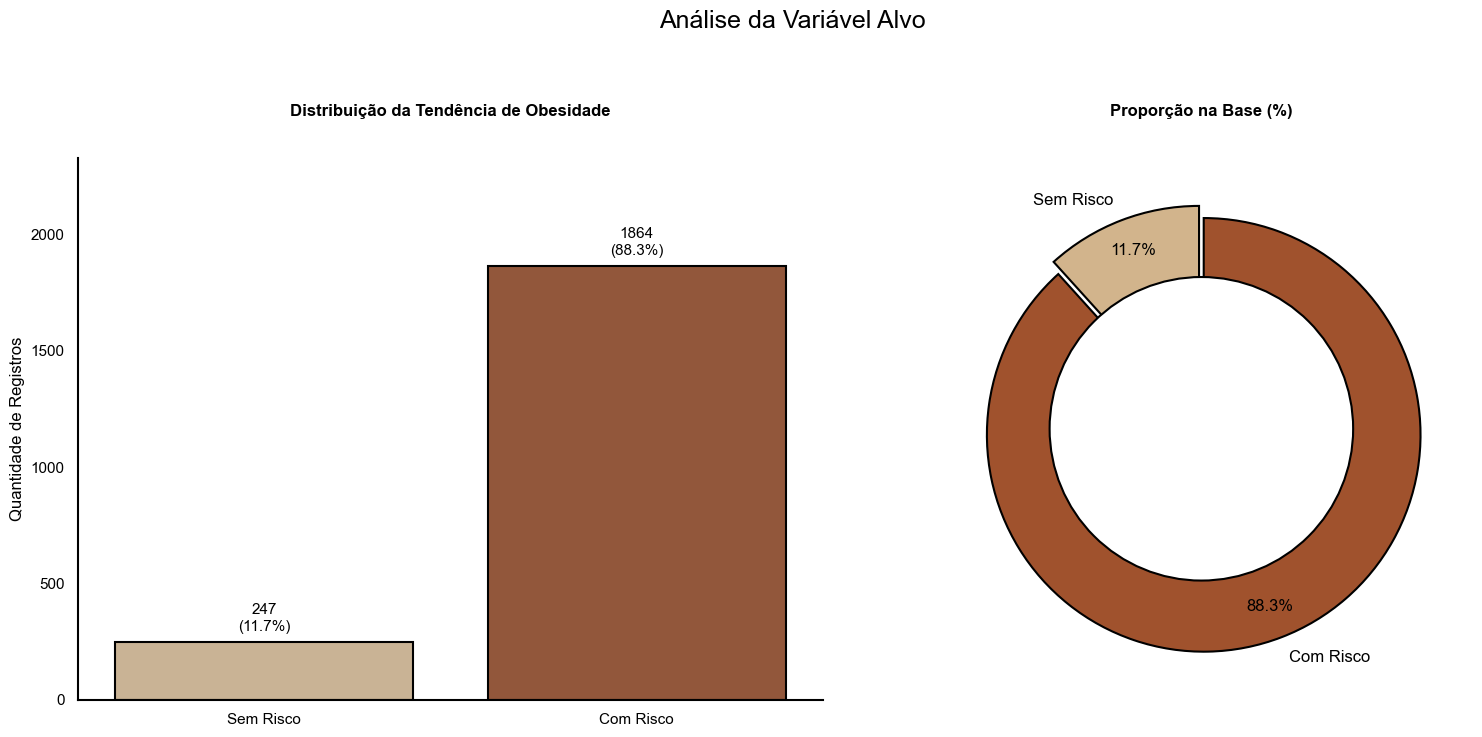

In [173]:
# 1. Garantir que as cores e o estilo global estejam carregados
configurar_estilo_terroso()

contagem = df_base['tendencia_obesidade'].value_counts().sort_index()
labels = ['Sem Risco', 'Com Risco']
cores_alvo = [cor_tan, cor_sienna] 

# Criamos a figura e os dois eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- GRÁFICO 1: BARRAS ---
sns.barplot(x=labels, y=contagem.values, palette=cores_alvo, ax=ax1, hue=labels, legend=False)

# Adicionando bordas pretas nas barras para combinar com a matriz
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Ajuste dinâmico do texto (Removido o fontweight='bold' a seu pedido)
espacamento = max(contagem.values) * 0.02
for i, v in enumerate(contagem.values):
    pct = (v / len(df_base)) * 100
    ax1.text(i, v + espacamento, f'{v}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=11, color='black')

ax1.set_ylim(0, max(contagem.values) * 1.25)
ax1.set_title('Distribuição da Tendência de Obesidade', pad=30)
ax1.set_ylabel('Quantidade de Registros', color='black')
sns.despine(ax=ax1) # Remove as bordas desnecessárias (topo e direita) conforme configurado

# --- GRÁFICO 2: ROSCA (DONUT) ---
# textprops ajustado para remover o negrito
wedges, texts, autotexts = ax2.pie(contagem, labels=labels, autopct='%1.1f%%', startangle=90, 
                                   colors=cores_alvo, pctdistance=0.85, explode=(0.03, 0.03), 
                                   textprops={'color': 'black', 'fontsize': 12})

# Adicionando bordas pretas nas fatias do gráfico de rosca
for wedge in wedges:
    wedge.set_edgecolor('black')
    wedge.set_linewidth(1.5)

# Cria o buraco do donut
ax2.add_artist(plt.Circle((0,0), 0.70, fc='white', edgecolor='black', linewidth=1.5))

ax2.set_title('Proporção na Base (%)', pad=30)

# Título Principal
plt.suptitle('Análise da Variável Alvo', fontsize=18, color='black', y=1.05)
plt.tight_layout()
plt.show()

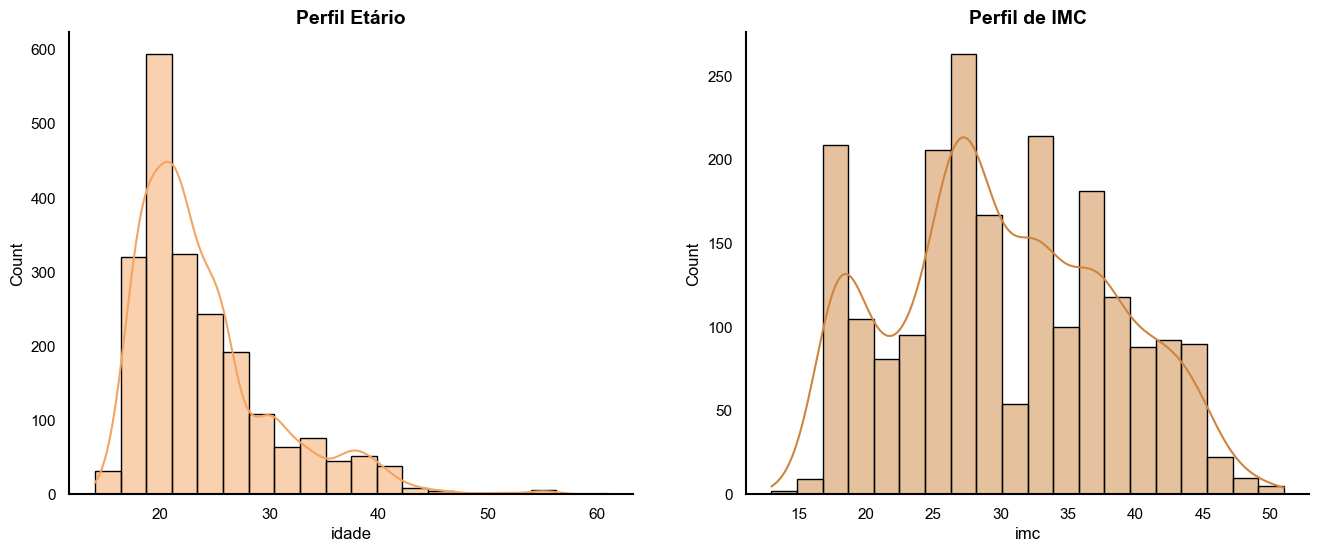

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Idade usando Sandy Brown com borda preta
sns.histplot(df_base['idade'], bins=20, kde=True, ax=ax1, color=cor_sand, edgecolor='black')
ax1.set_title('Perfil Etário', fontsize=14)

# IMC usando Peru (Ocre) com borda preta
sns.histplot(df_base['imc'], bins=20, kde=True, ax=ax2, color=cor_peru, edgecolor='black')
ax2.set_title('Perfil de IMC', fontsize=14)

sns.despine()
plt.show()

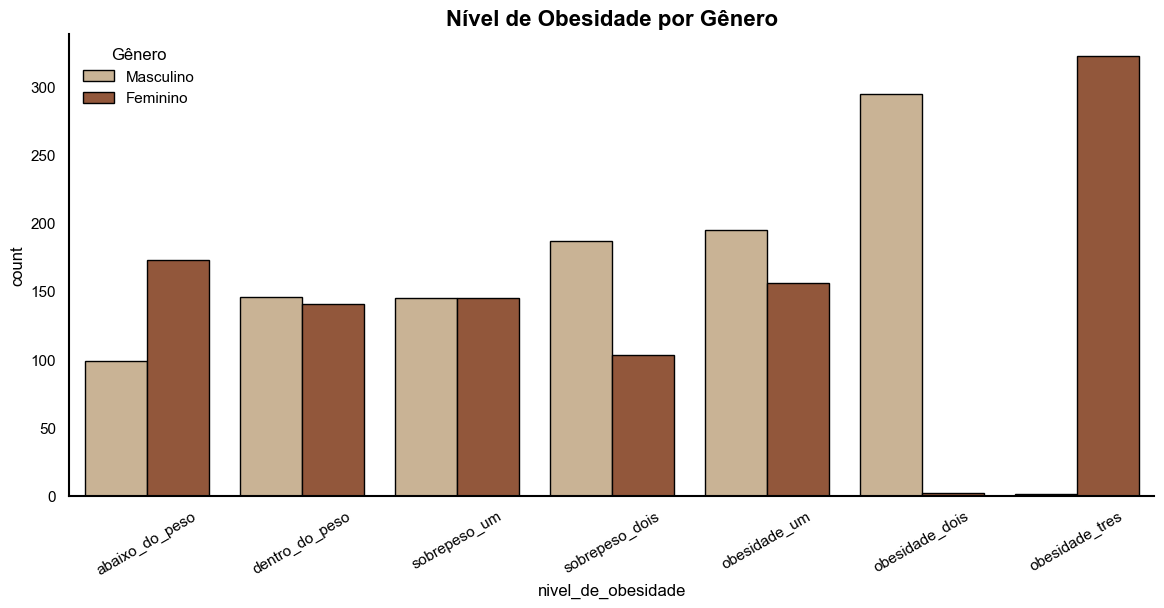

In [175]:
ordem_obesidade = ['abaixo_do_peso', 'dentro_do_peso', 'sobrepeso_um', 'sobrepeso_dois', 'obesidade_um', 'obesidade_dois', 'obesidade_tres']

plt.figure(figsize=(14, 6))
# Adicionando bordas pretas nas barras do countplot
ax = sns.countplot(data=df_base, x='nivel_de_obesidade', hue='genero', 
                   order=ordem_obesidade, palette=[cor_tan, cor_sienna])

# Loop para aplicar borda preta em cada barra
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

plt.title('Nível de Obesidade por Gênero', fontsize=16)
plt.xticks(rotation=30)
plt.legend(title='Gênero', labels=['Masculino', 'Feminino'])
sns.despine()
plt.show()

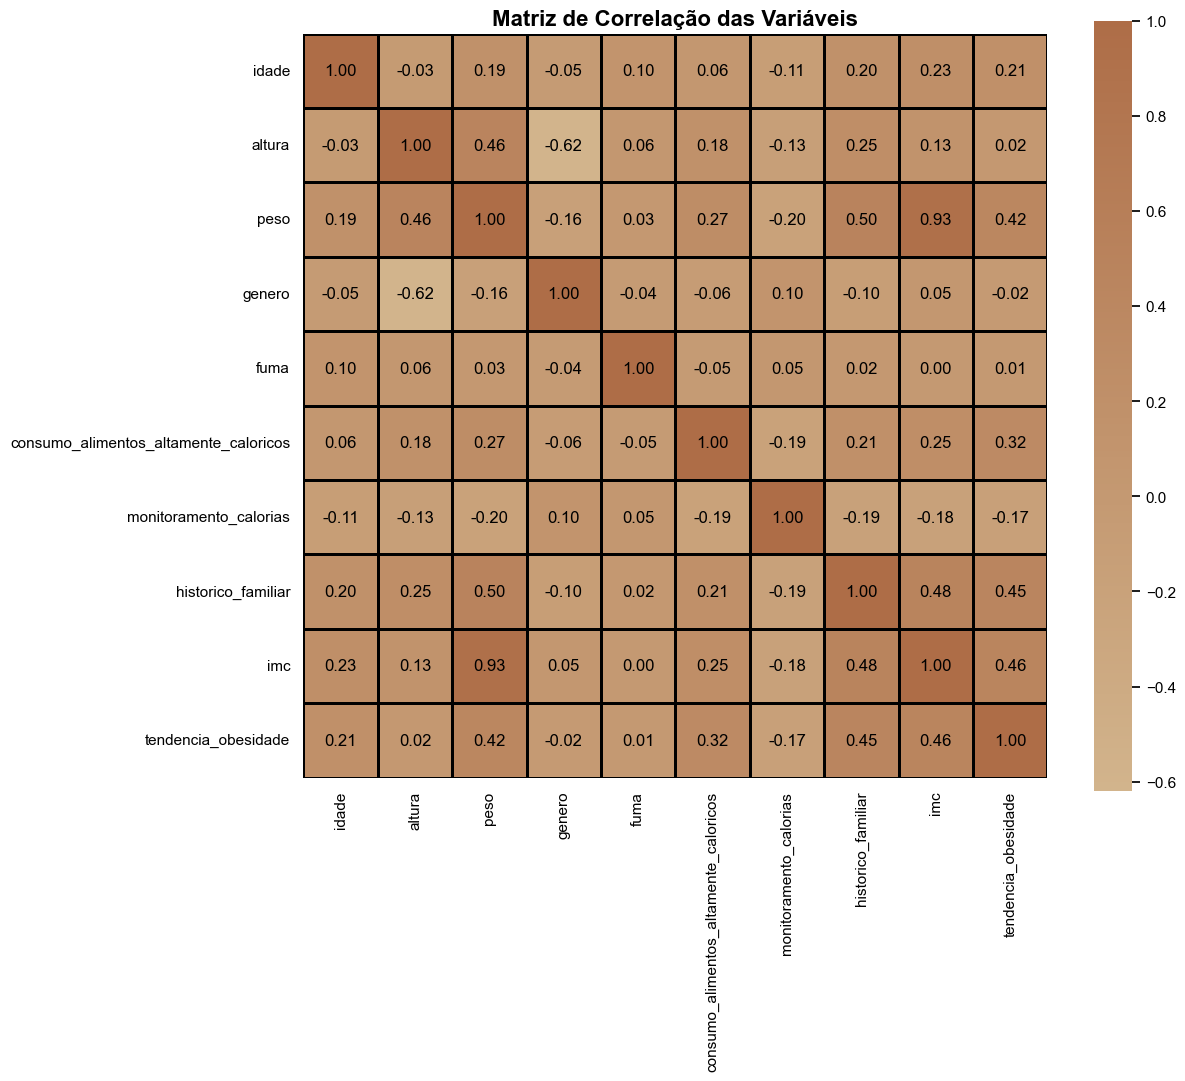

In [177]:
df_numeric = df_base.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
# Usando o cmap_terroso e forçando cores dos números para preto
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap=cmap_terroso, 
            center=0.5, square=True, linewidths=1, linecolor='black',
            annot_kws={"color": 'black'}) # Números em preto

plt.title('Matriz de Correlação das Variáveis', fontsize=16)
plt.show()

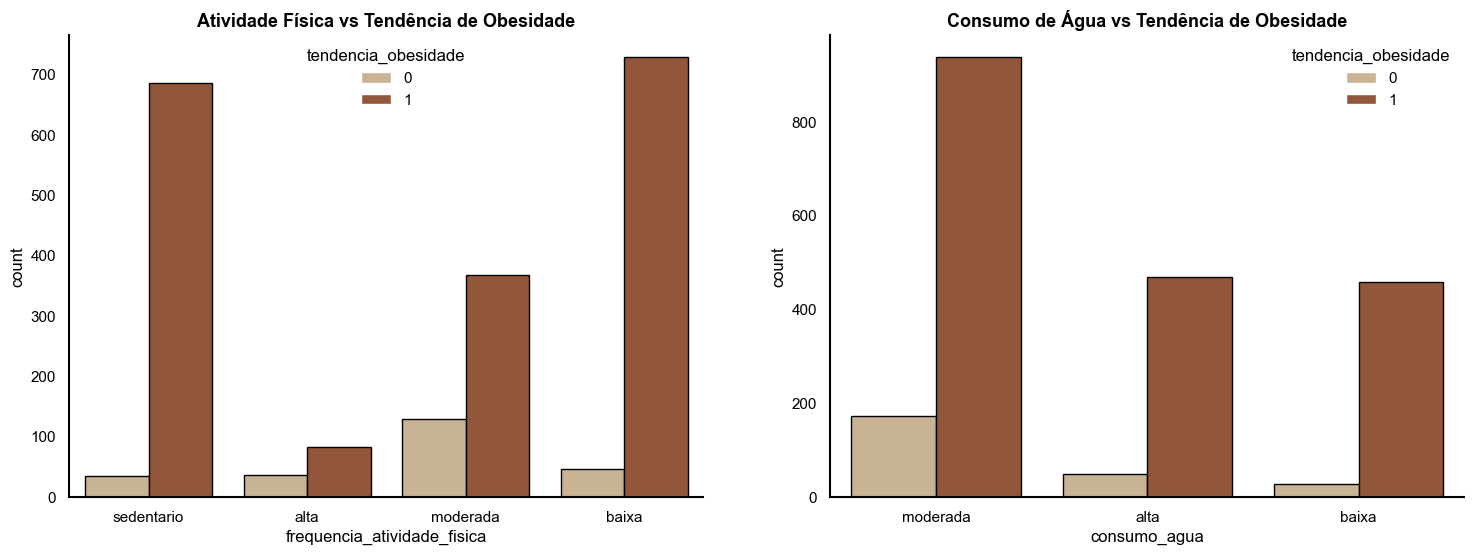

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Atividade Física
sns.countplot(data=df_base, x='frequencia_atividade_fisica', hue='tendencia_obesidade', 
              ax=ax[0], palette=[cor_tan, cor_sienna])
ax[0].set_title('Atividade Física vs Tendência de Obesidade', fontsize=13)

# Consumo de Água
sns.countplot(data=df_base, x='consumo_agua', hue='tendencia_obesidade', 
              ax=ax[1], palette=[cor_tan, cor_sienna])
ax[1].set_title('Consumo de Água vs Tendência de Obesidade', fontsize=13)

# Aplicando bordas pretas em ambos os subplots
for a in ax:
    for patch in a.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(1)

sns.despine()
plt.show()

## Aplicação dos modelos

In [119]:
# Exclui colunas target
df_base_modelo = df_base.drop(['peso', 'altura','nivel_de_obesidade','imc'], axis=1)
df_base_modelo.head()

,idade,genero,consumo_refeicoes_principais,consumo_vegetais,consumo_agua,frequencia_atividade_fisica,tempo_uso_tecnologia,fuma,consumo_alimentos_altamente_caloricos,monitoramento_calorias,historico_familiar,consumo_lanches_entre_refeicoes,consumo_alcool,meio_de_transporte,tendencia_obesidade
0,21,1,tres_refeicoes_por_dia,as_vezes,moderada,sedentario,moderada,0,0,0,1,baixa,nunca,transporte_publico,0
1,21,1,tres_refeicoes_por_dia,sempre,alta,alta,baixa,1,0,1,1,baixa,baixa,transporte_publico,0
2,23,0,tres_refeicoes_por_dia,as_vezes,moderada,moderada,moderada,0,0,0,1,baixa,moderada,transporte_publico,0
3,27,0,tres_refeicoes_por_dia,sempre,moderada,moderada,baixa,0,0,0,0,baixa,moderada,caminhada,1
4,22,0,uma_refeicao_por_dia,as_vezes,moderada,sedentario,baixa,0,0,0,0,baixa,baixa,transporte_publico,1


In [120]:
# Definindo colunas
features_categoricas = ['genero', 'consumo_refeicoes_principais', 'consumo_vegetais', 
                       'consumo_agua', 'frequencia_atividade_fisica', 'tempo_uso_tecnologia',
                       'consumo_alcool', 'meio_de_transporte', 'consumo_lanches_entre_refeicoes']
features_numericas = ['idade', 'fuma', 'consumo_alimentos_altamente_caloricos', 'monitoramento_calorias',
                      'historico_familiar']

# Preprocessamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ])

In [121]:
# 1. Preparação dos dados fora da função
X = df_base_modelo.drop('tendencia_obesidade', axis=1)
y = df_base_modelo['tendencia_obesidade']

# Split da base com stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# 3. Execução Final
df_ranking, pipes = treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor)

# Exibição dos resultados
print("\nRANKING FINAL DE MODELOS:")
print(df_ranking.to_string(index=False))


RANKING FINAL DE MODELOS:
             Modelo  Acurácia  Precisão   Recall  F1-score  AUC-ROC Overfit (%)
      Random Forest  0.959811  0.958869 0.997326  0.977720 0.980383       4.02%
            XGBoost  0.955083  0.963446 0.986631  0.974901 0.977573       4.49%
Logistic Regression  0.926714  0.938619 0.981283  0.959477 0.957219       0.81%


## Análise gráficas dos modelos

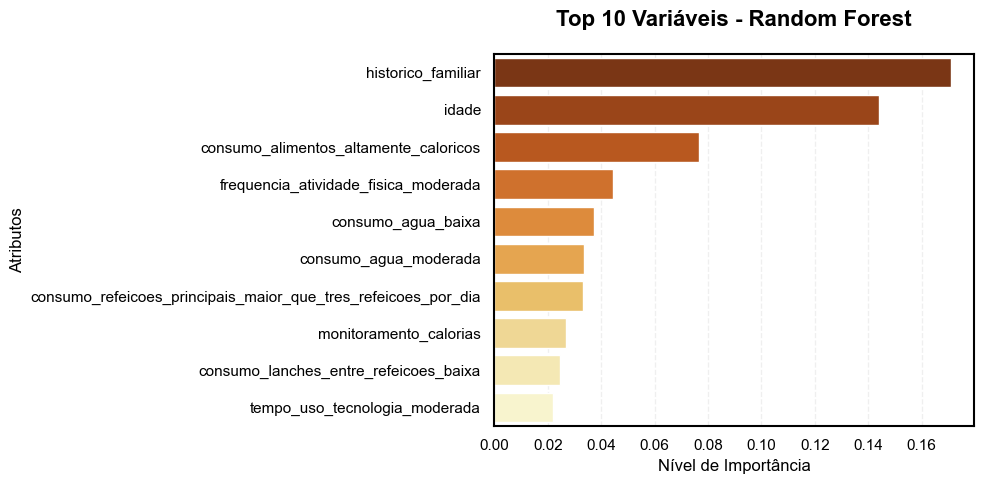

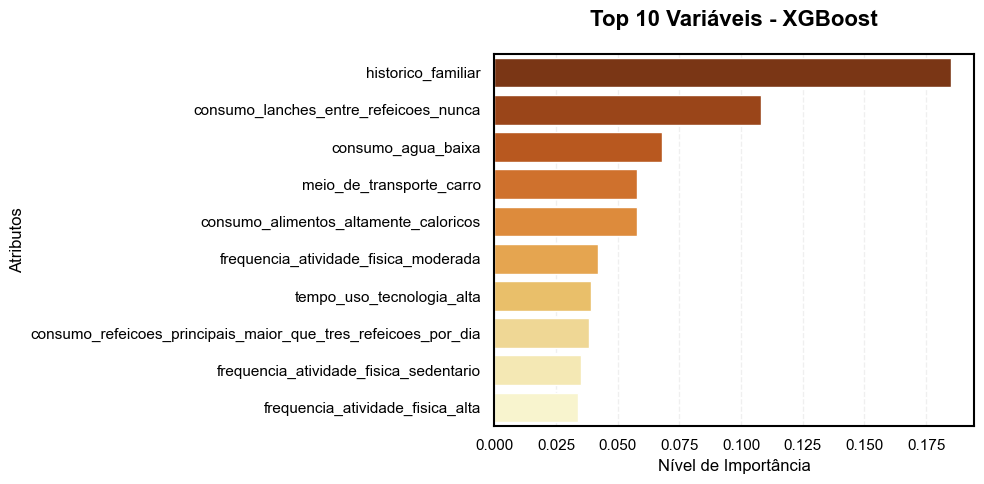

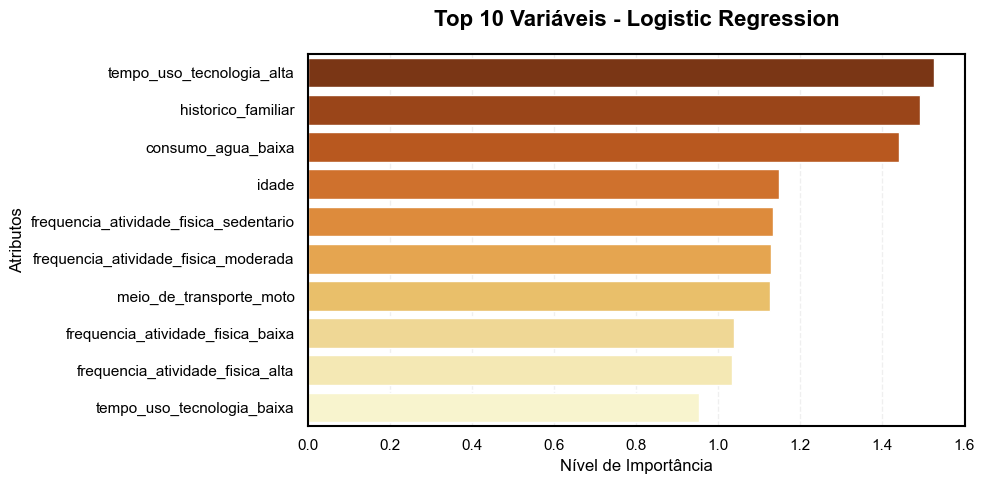

In [172]:
# Importância para o Random Forest (O modelo com melhor Recall)
plot_importancia_modelos(pipes['Random Forest'], 'Random Forest')

# Importância para o XGBoost (O modelo com melhor Precisão)
plot_importancia_modelos(pipes['XGBoost'], 'XGBoost')

# Importância para a Regressão Logística (O modelo mais estável)
plot_importancia_modelos(pipes['Logistic Regression'], 'Logistic Regression')

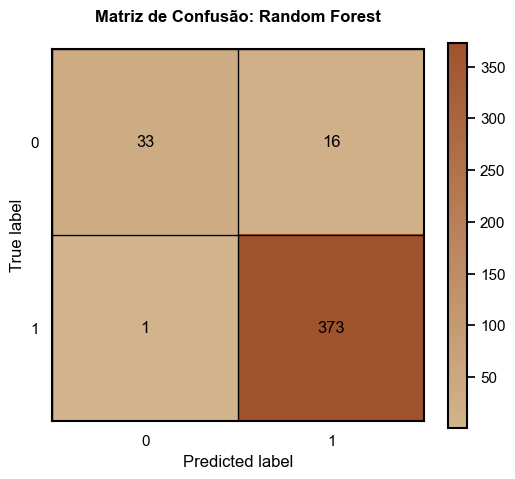

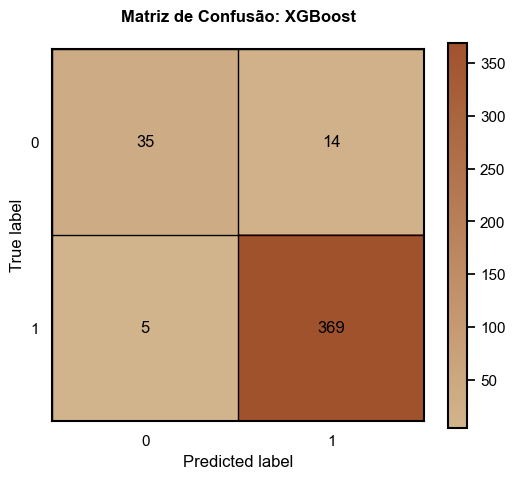

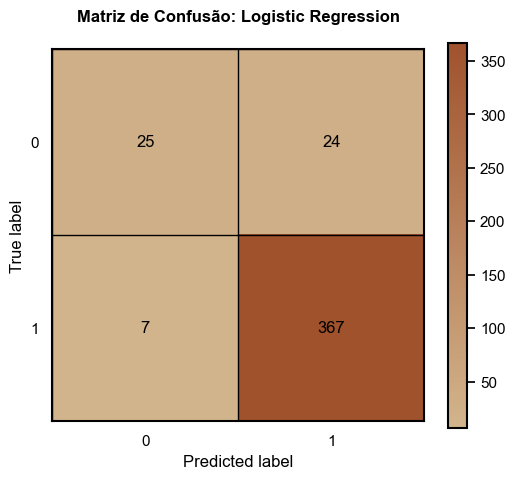

In [170]:
# Compara os três modelos em relação á matriz de confusão
plot_matriz_confusao(pipes['Random Forest'], X_test, y_test, 'Random Forest')
plot_matriz_confusao(pipes['XGBoost'], X_test, y_test, 'XGBoost')
plot_matriz_confusao(pipes['Logistic Regression'], X_test, y_test, 'Logistic Regression')

## Escolha do modelo a ser utilizado

#### Desempenho em Métricas de Classificação

- O Random Forest apresentou o melhor equilíbrio, superando a Regressão Logística e o XGBoost, por conta dos motivos abaixo:

- **Recall de 0.997:** Esta é a métrica mais importante, pois um Recall alto significa que o modelo quase não deixa passar casos de "Risco" (Falsos Negativos). Em saúde, é preferível um "alarme falso" (Falso Positivo) do que ignorar alguém que realmente precisa de atenção.

- **F1-Score:** Ao equilibrar precisão e recall, o Random Forest manteve a maior consistência, garantindo que o modelo não está apenas chutando uma classe, mas sim entendendo os padrões.

#### AUC-ROC e Capacidade de Separação

- A AUC-ROC próxima de 1.0 indica que o Random Forest tem uma capacidade quase perfeita de distinguir entre quem tem tendência à obesidade e quem não tem. Ele lida muito bem com as variáveis categóricas (como frequência de atividade física e consumo de água).

#### Análise da Matriz de Confusão

- Na Matriz de Confusão do Random Forest, observamos:

    - **Mínimos Falsos Negativos:** O quadrante inferior esquerdo (onde o modelo diz que é saudável, mas é risco) foi o menor entre os três modelos.

    - **Estabilidade:** O modelo mostrou-se muito robusto nos acertos de "Verdadeiros Positivos".

#### Controle de Overfit

- Embora o Random Forest tenha métricas muito altas (o que poderia sugerir overfit), ele se justifica porque:

    - A base de dados possui regras claras criadas pela função risco_obesidade.

    - O modelo de árvore consegue mapear exatamente os "degraus" (ex: Score >= 3) que definimos na lógica de negócio.

    - Diferente do XGBoost, o Random Forest é menos propenso a decorar ruídos específicos, sendo mais estável para novos dados.

In [182]:
pd.set_option('display.max_colwidth', None)

# Cria o dicionário com as informações consolidadas
comparativo_modelos = {
    'Critério': [
        'Segurança (Recall)', 
        'Poder de Decisão', 
        'Interpretabilidade', 
        'Estabilidade (Overfit)',
        'Veredito Final'
    ],
    'Melhor Modelo': [
        'Random Forest', 
        'Random Forest', 
        'Logistic Regression', 
        'Random Forest',
        'RANDOM FOREST'
    ],
    'Justificativa Técnica': [
        'Recall de 0.997: essencial em saúde para não ignorar casos de risco.',
        'Captura melhor as relações complexas entre hábitos de vida e genética.',
        'Modelo linear mais simples, porém com menor poder preditivo.',
        'Excelente generalização das regras de negócio sem decorar ruídos.',
        'Melhor equilíbrio entre acurácia, precisão e segurança clínica.'
    ]
}

# Cria o DataFrame
df_escolha_modelo = pd.DataFrame(comparativo_modelos)

# Exibe a tabela
display(df_escolha_modelo)

,Critério,Melhor Modelo,Justificativa Técnica
0,Segurança (Recall),Random Forest,Recall de 0.997: essencial em saúde para não ignorar casos de risco.
1,Poder de Decisão,Random Forest,Captura melhor as relações complexas entre hábitos de vida e genética.
2,Interpretabilidade,Logistic Regression,"Modelo linear mais simples, porém com menor poder preditivo."
3,Estabilidade (Overfit),Random Forest,Excelente generalização das regras de negócio sem decorar ruídos.
4,Veredito Final,RANDOM FOREST,"Melhor equilíbrio entre acurácia, precisão e segurança clínica."


In [184]:
# 1. Define a estrutura de pastas para o modelo
diretorio_pai = Path.cwd().parent
# Criaremos uma pasta chamada 'models' dentro do seu projeto
pasta_modelos = diretorio_pai / 'models'

# 2. Cria a pasta se não existir
pasta_modelos.mkdir(parents=True, exist_ok=True)

# 3. Define o nome do arquivo 
nome_modelo = 'modelo_final_random_forest.joblib'
caminho_modelo = pasta_modelos / nome_modelo

# 4. Salva o PIPELINE completo
# Importante: Salvamos o 'pipe' porque ele já contém o preprocessor + o modelo treinado
vencedor = df_ranking.iloc[0]['Modelo'] # Pega o nome do vencedor do seu ranking
melhor_pipe = pipes[vencedor]

joblib.dump(melhor_pipe, caminho_modelo)

print("-" * 30)
print(f"✅ Modelo salvo com sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'models'")
print(f"📄 Arquivo: {nome_modelo}")
print("-" * 30)

------------------------------
✅ Modelo salvo com sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'models'
📄 Arquivo: modelo_final_random_forest.joblib
------------------------------
